In [1]:
%cd /home/yokoyama/research
from types import SimpleNamespace
import sys
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from sklearn.manifold import TSNE
from umap import UMAP

sys.path.append(".")
from modules.individual import IndividualActivityRecognition, IndividualDataFormat, IndividualDataHandler, IndividualPredTypes
from modules.utils.constants import Stages

/raid6/home/yokoyama/research


In [2]:
# set constants
model_type = "ganomaly"
train_data_dir = os.path.join("data", "dataset01", "train")
test_data_dir = os.path.join("data", "dataset01", "test")
data_types = ["bbox"]
seq_len = 150
masking = False

In [3]:
# load results
def load_results(data_dir, model_type, data_type, seq_len, data_keys):
    results = {}
    for data_dir in tqdm(sorted(glob(os.path.join(data_dir, "*")))):
        video_num = os.path.basename(data_dir)
        results[video_num] = IndividualDataHandler.load(data_dir, model_type, data_type, masking, seq_len, IndividualPredTypes.anomaly, data_keys)

    return results

def get_results_ind(results):
    results_ind = {}
    for video_num, video_results in tqdm(results.items()):
        ind_results = {}
        for item in video_results:
            pid = item[IndividualDataFormat.id]
            if pid not in ind_results:
                # initialize individual data
                ind_results[pid] = {
                    key: [] for key in IndividualDataFormat.get_attributes()
                    if key != IndividualDataFormat.id
                }

            # append individual data
            for key, value in item.items():
                if key != IndividualDataFormat.id:
                    ind_results[pid][key].append(item[key])
        results_ind[video_num] = ind_results
    return results_ind

def get_results(train_data_dir, test_data_dir, model_type, data_types, seq_len, data_name):
    train_results = {}
    test_results = {}
    for data_type in data_types:
        train_results[data_type] = load_results(train_data_dir, model_type, data_type, seq_len, [data_name])
        test_results[data_type] = load_results(test_data_dir, model_type, data_type, seq_len, [data_name])

    train_results_ind = {}
    test_results_ind = {}
    for data_type in data_types:
        results = get_results_ind(train_results[data_type])
        # change data structure
        for video_num, vals in results.items():
            if video_num not in train_results_ind:
                train_results_ind[video_num] = {}
            train_results_ind[video_num][data_type] = vals

        results = get_results_ind(test_results[data_type])
        # change data structure
        for video_num, vals in results.items():
            if video_num not in test_results_ind:
                test_results_ind[video_num] = {}
            test_results_ind[video_num][data_type] = vals

    del test_results
    return train_results, train_results_ind, test_results_ind

In [4]:
def create_mappers(train_results, data_name):
    train_all_vals = {}
    for data_type in data_types:
        train_all_vals[data_type] = get_all_values(
            train_results[data_type], data_name
        )
        
    print("fitting")
    mappers = {}
    for data_type, vals in tqdm(train_all_vals.items()):
        # mapper = TSNE(
        #     n_components=2, learning_rate="auto", init="pca", random_state=42
        # )
        mapper = UMAP(
            n_neighbors=8,
            min_dist=0.0,
            n_components=2,
            random_state=42,
        )
        mapper.fit(np.array(vals))
        mappers[data_type] = mapper
        
    del train_all_vals
    return mappers
        
def get_all_values(results, data_name):
    x = []
    for video_num, video_results in tqdm(results.items()):
        for item in video_results:
            val = item[data_name]
            x.append(val)
    return x

In [5]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 16
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in


def plot(results, data_name, mappers, stage, frame_num=None):
    for video_num, video_results in results.items():
        fig, axs = plt.subplots(1, len(video_results), figsize=(4 * len(mappers) + 2, 4))
        fig.subplots_adjust(hspace=0.3, wspace=0.15)
        for i, (data_type, ind_results) in enumerate(video_results.items()): 
            for pid, ind_result in ind_results.items():
                frame_nums = ind_result[IndividualDataFormat.frame_num]
                vals = ind_result[data_name]
                
                # reduce dimention
                vals = mappers[data_type].transform(vals)
                x, y = vals.T

                if type(axs) == list:
                    axs[i].scatter(x, y, label=pid, alpha=0.2, s=8)
                else:
                    axs.scatter(x, y, label=pid, alpha=0.2, s=8)
                del x, y, frame_nums, vals

        if type(axs) == list:
            legend = axs[-1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        else:
            legend = axs.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        for lh in legend.legend_handles: 
            lh.set_alpha(1)  # reset alpha of labels on legend
        
        # save fig
        # path = os.path.join(
        #     "data", "images", "individual", model_type, data_name, f"{stage}", f"{video_num}.jpg"
        # )
        # os.makedirs(os.path.dirname(path), exist_ok=True)
        # plt.savefig(path, bbox_inches='tight')
        
        # show
        print(video_num)
        plt.show()
        del fig, axs

# E Z

In [6]:
data_name = IndividualDataFormat.z
train_results, train_results_ind, test_results_ind = get_results(train_data_dir, test_data_dir, model_type, data_types, seq_len, data_name)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
mappers = create_mappers(train_results, data_name)
del train_results

  0%|          | 0/20 [00:00<?, ?it/s]

fitting


  0%|          | 0/1 [00:00<?, ?it/s]

01


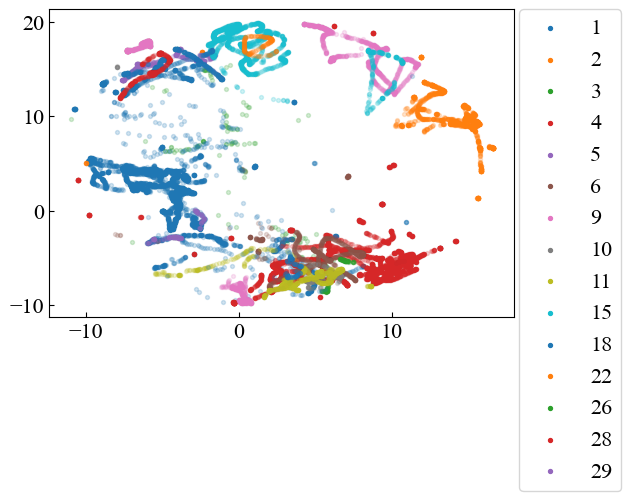

02


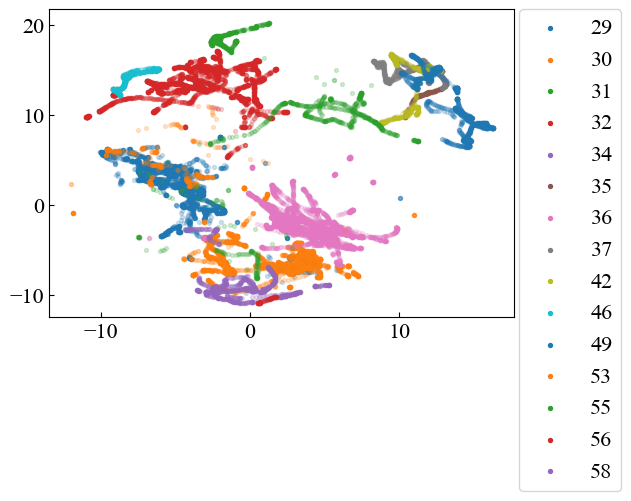

03


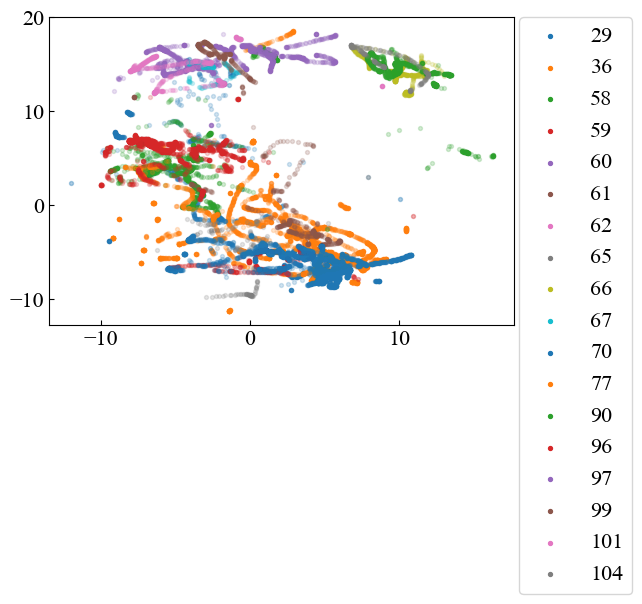

04


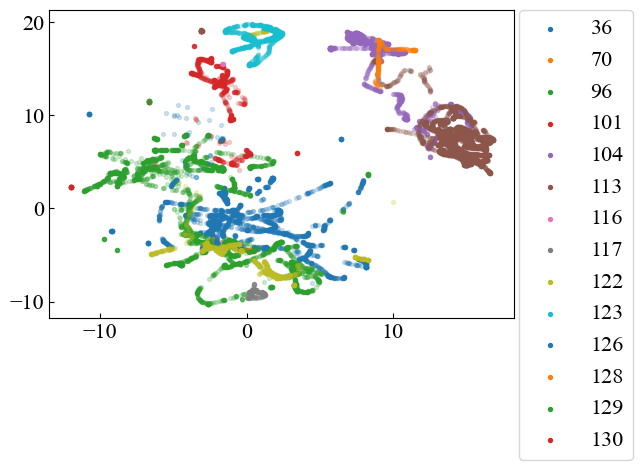

05


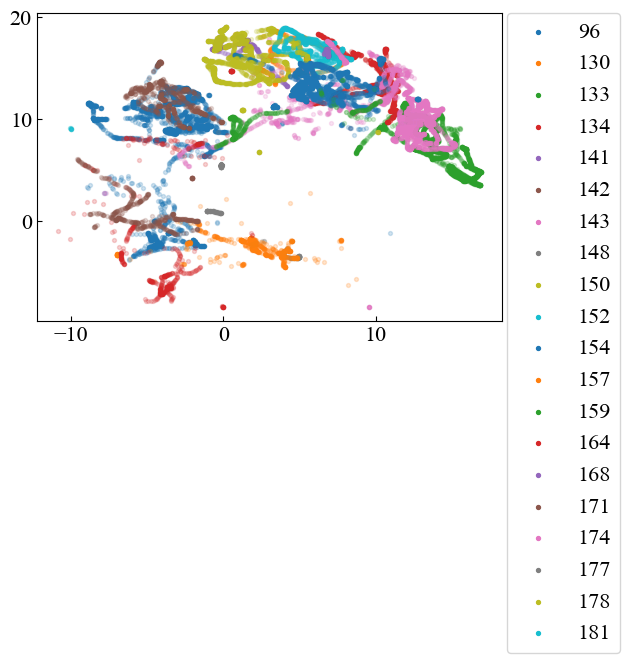

06


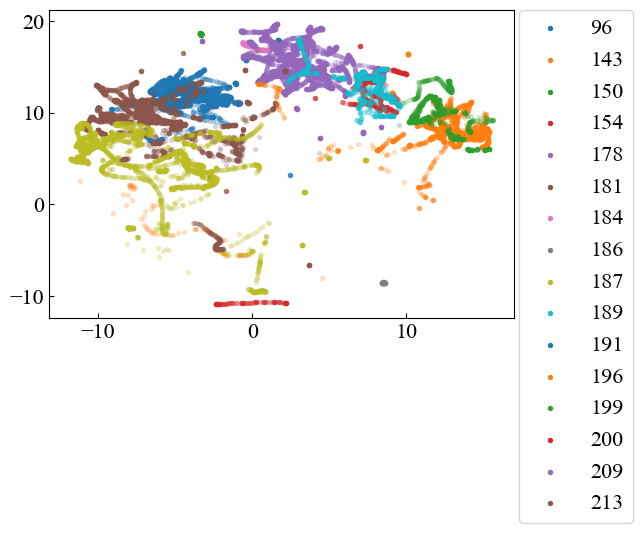

07


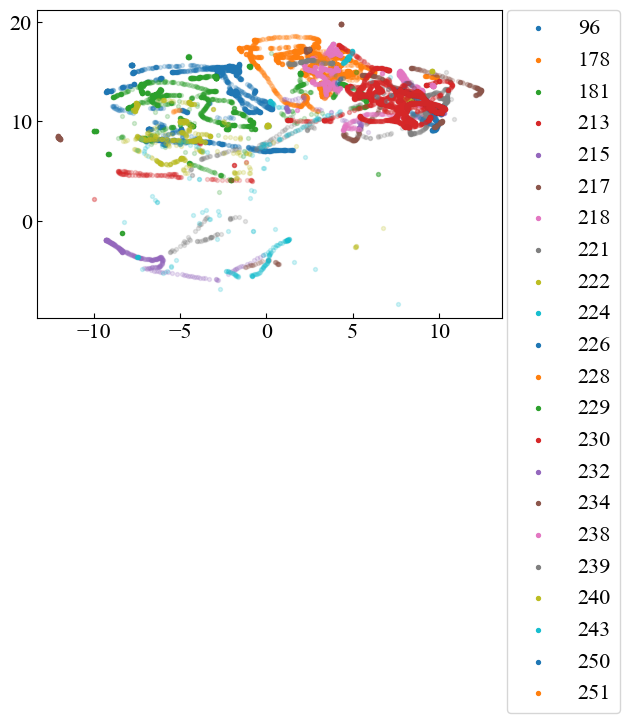

08


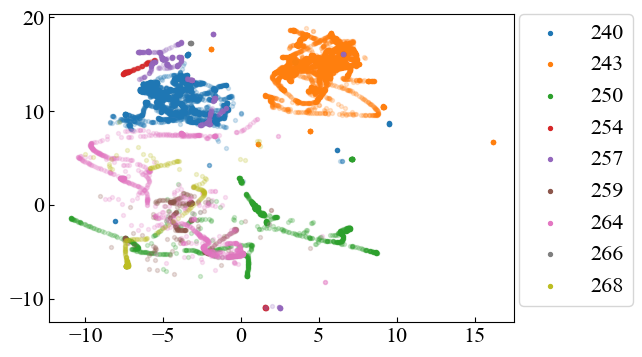

09


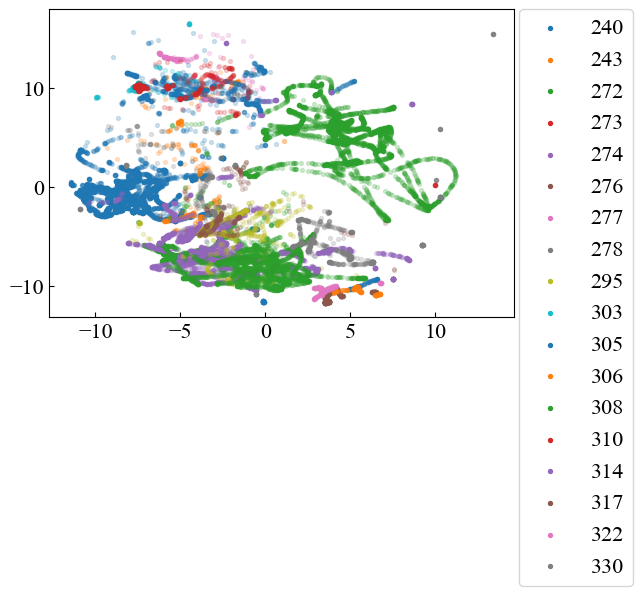

10


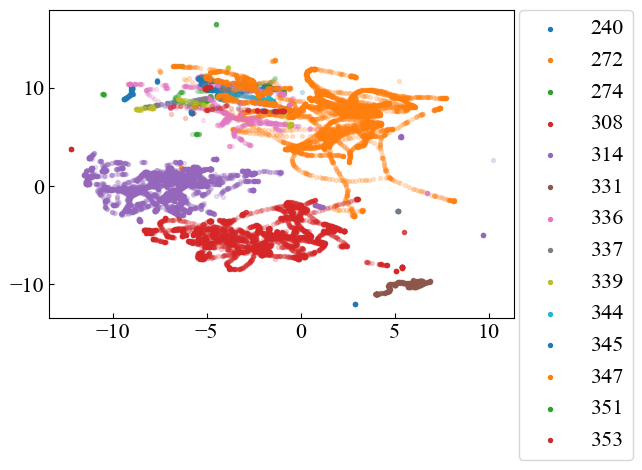

11


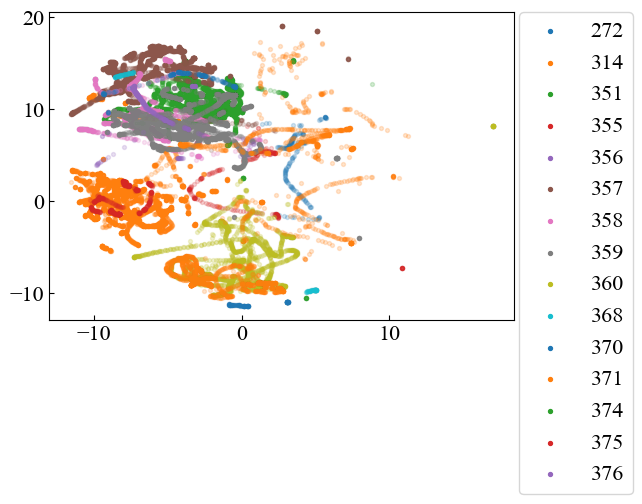

12


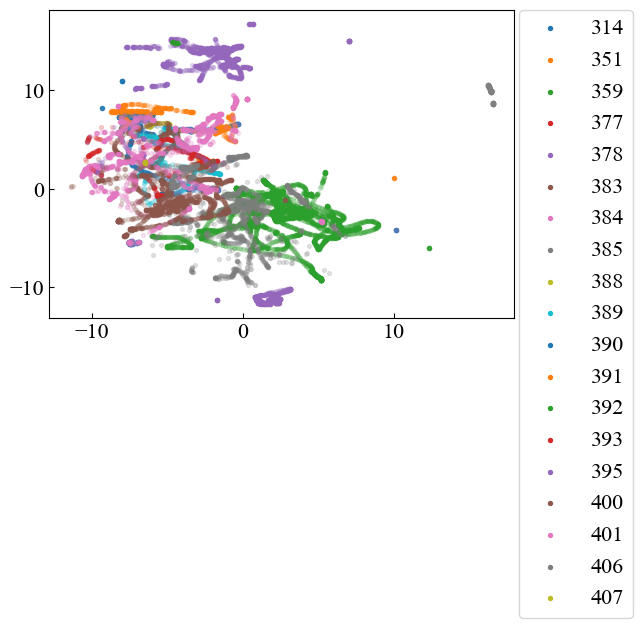

13


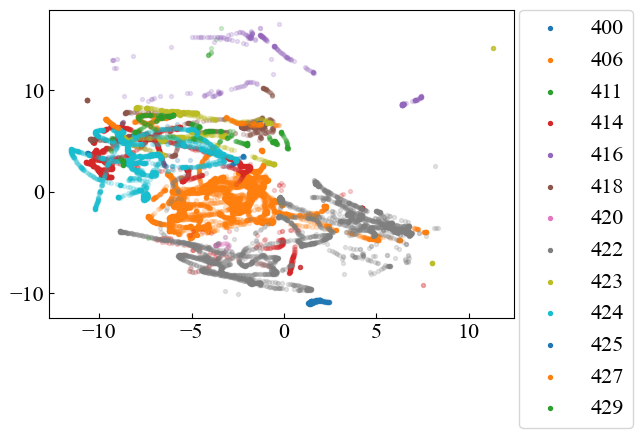

14


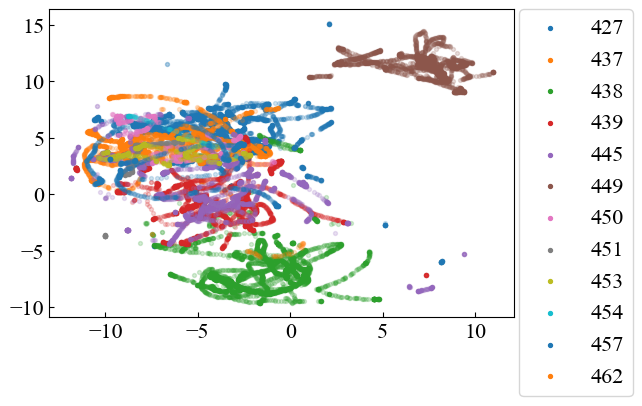

15


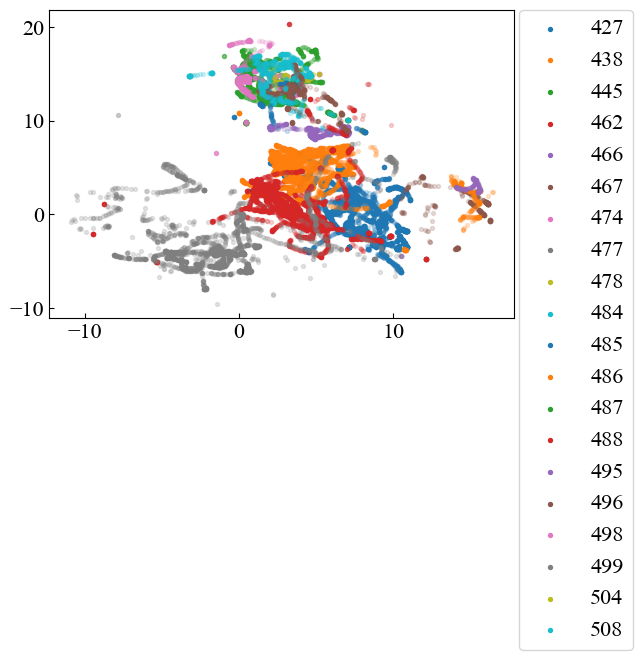

16


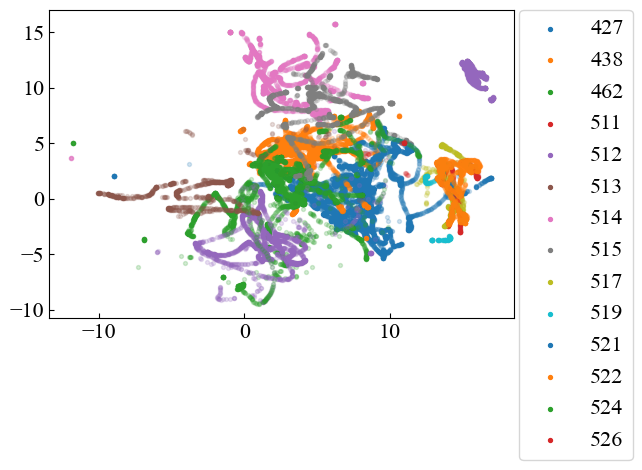

17


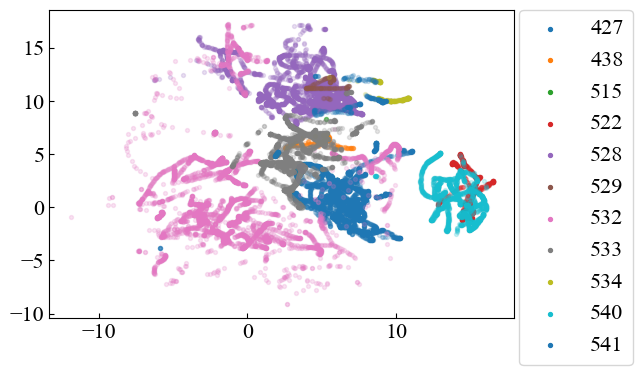

18


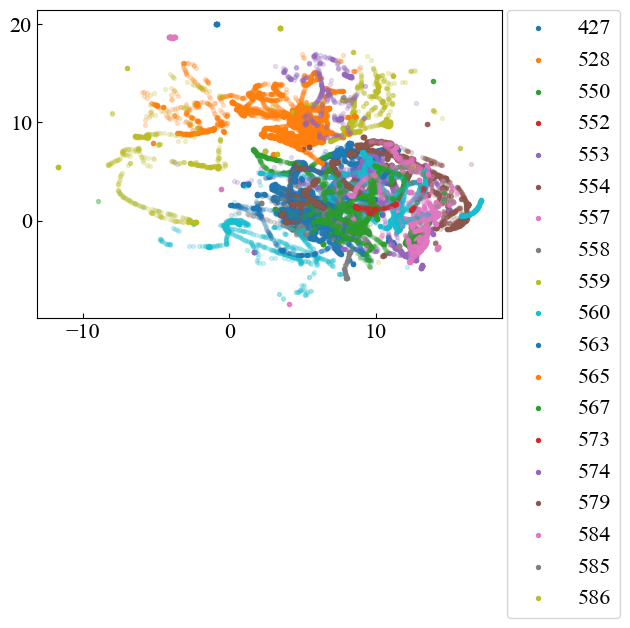

19


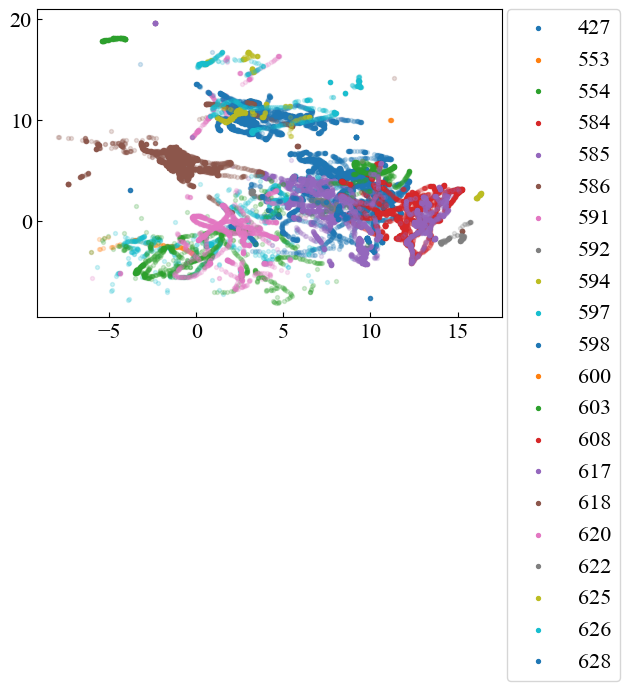

20


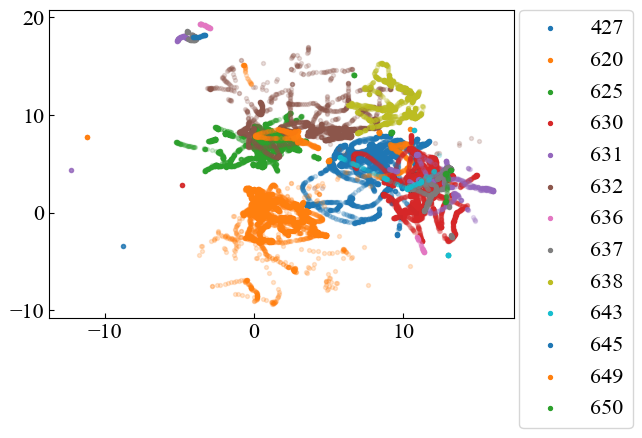

In [8]:
plot(train_results_ind, data_name, mappers, "train")

01


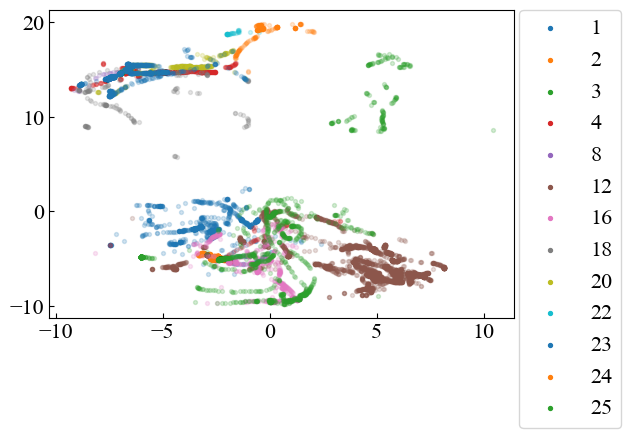

02


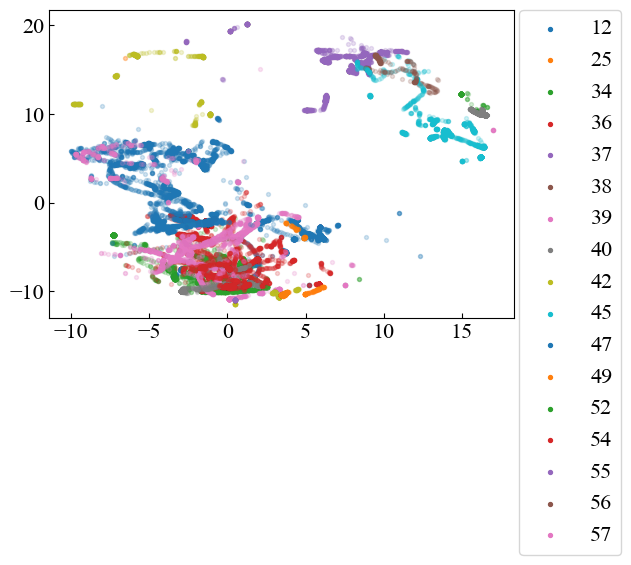

03


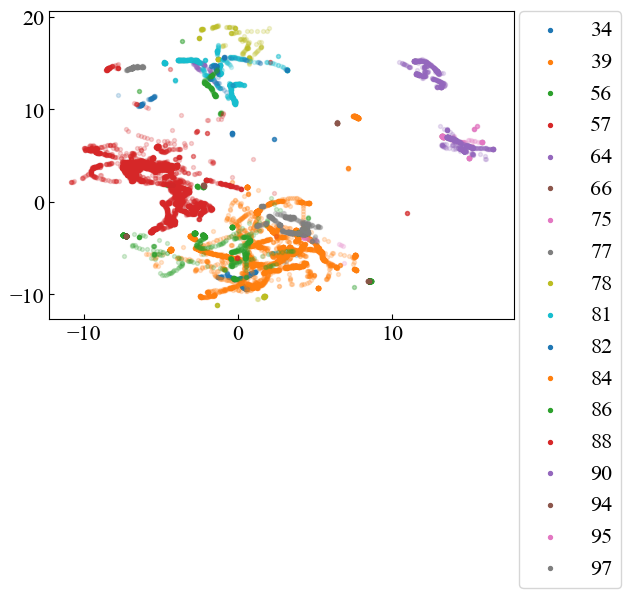

04


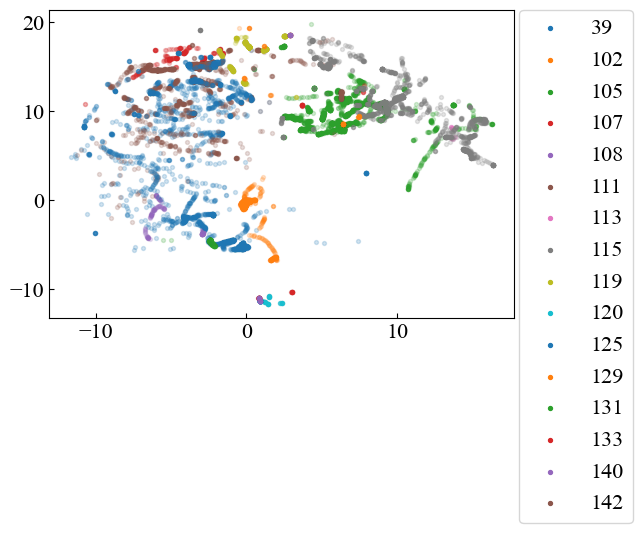

05


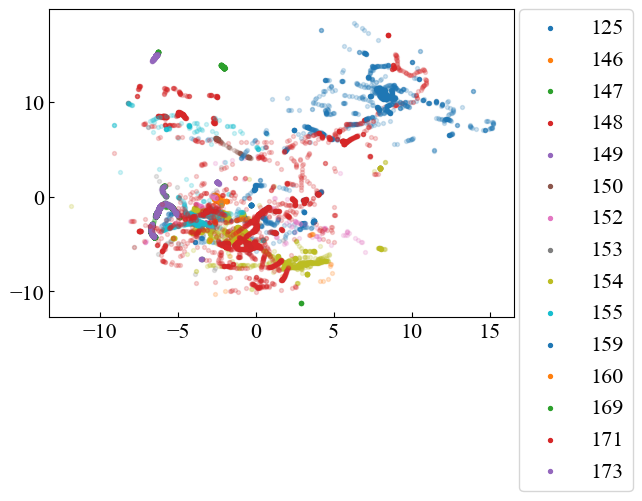

06


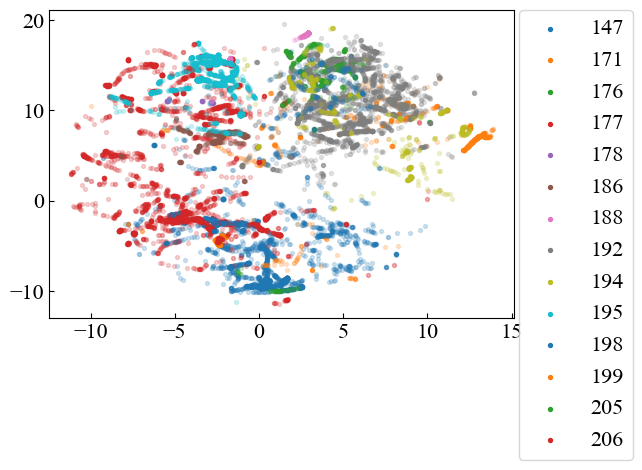

07


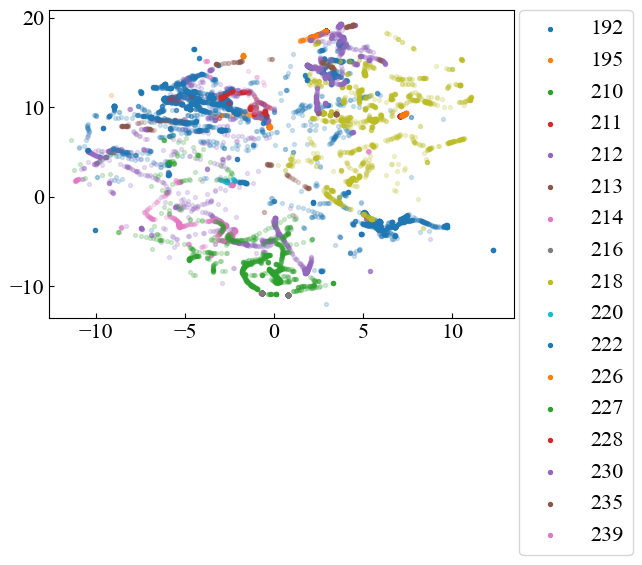

08


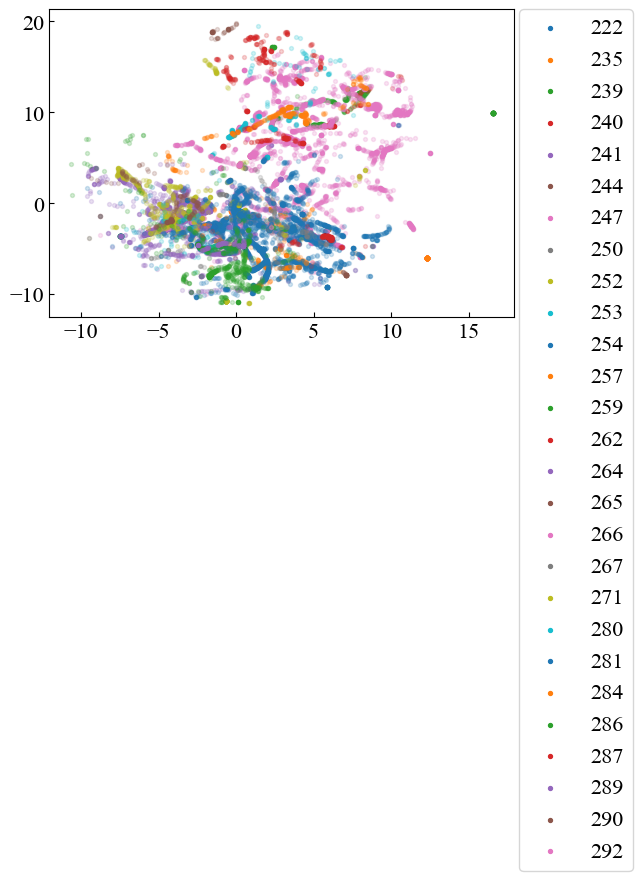

09


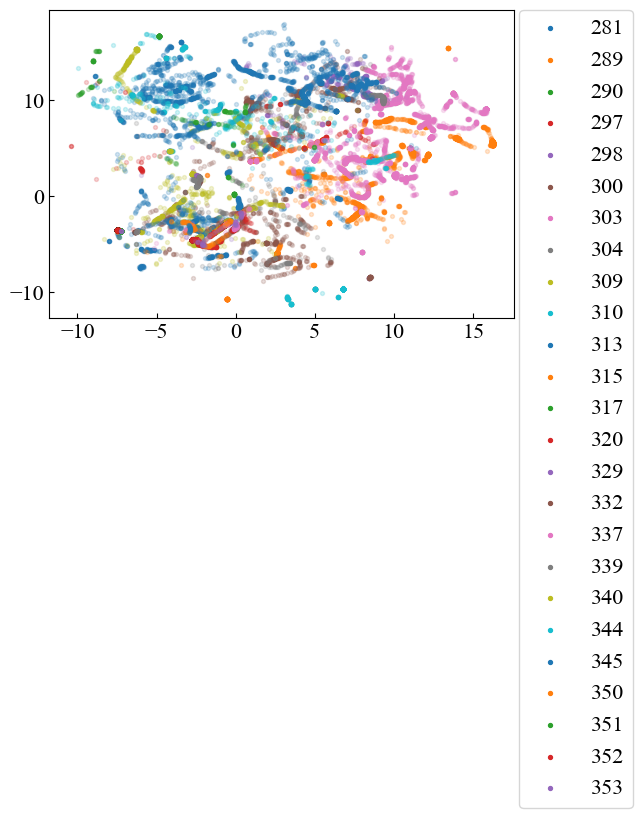

10


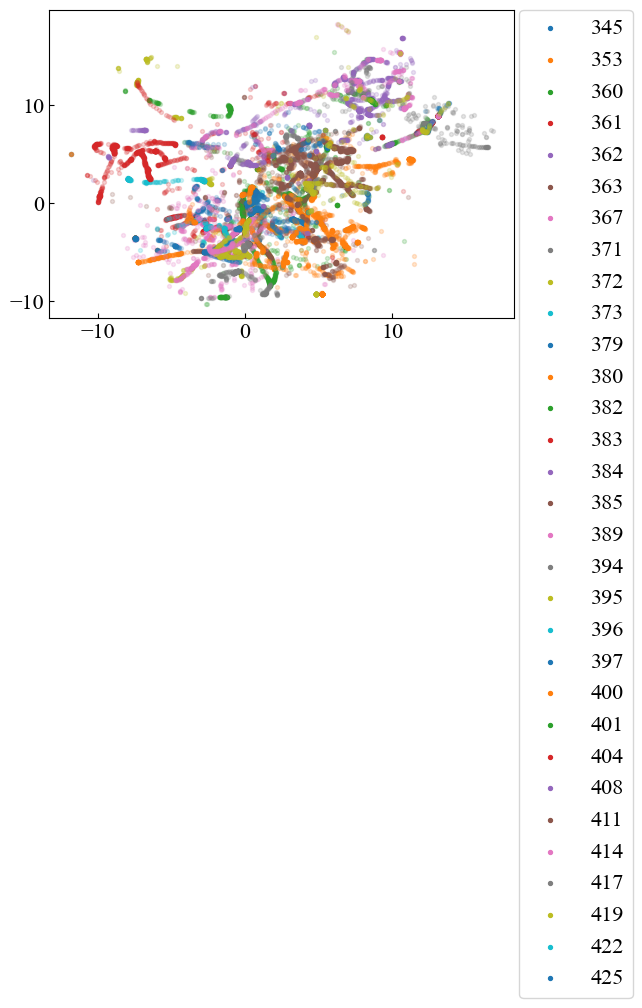

11


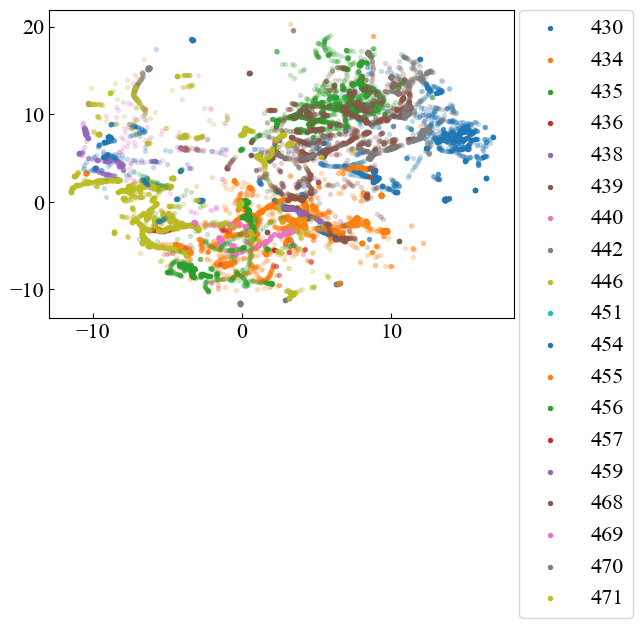

12


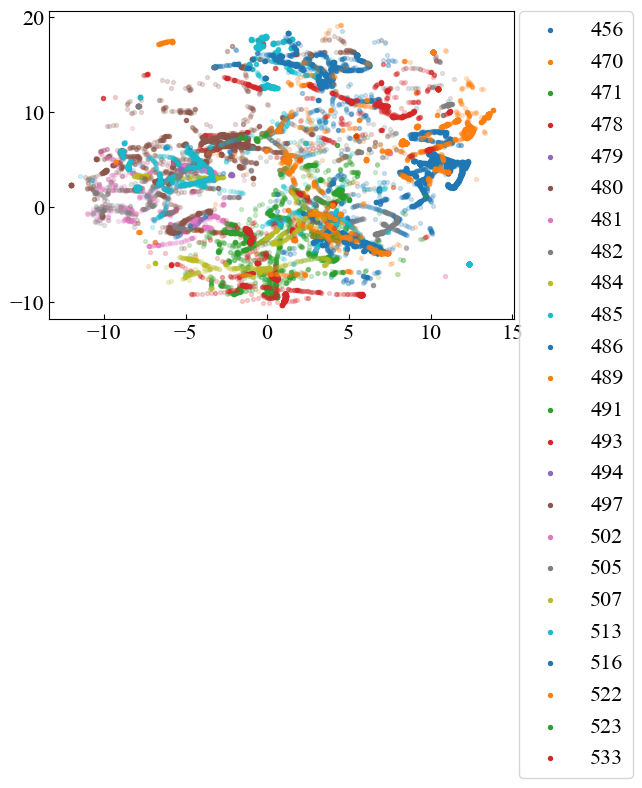

13


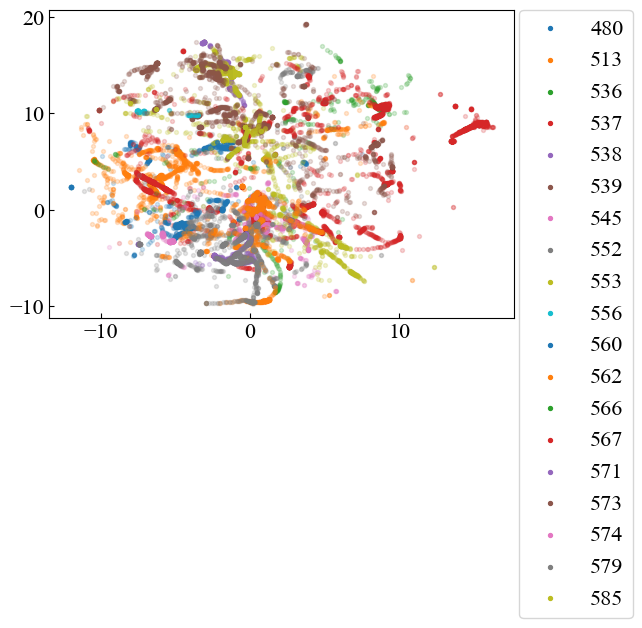

14


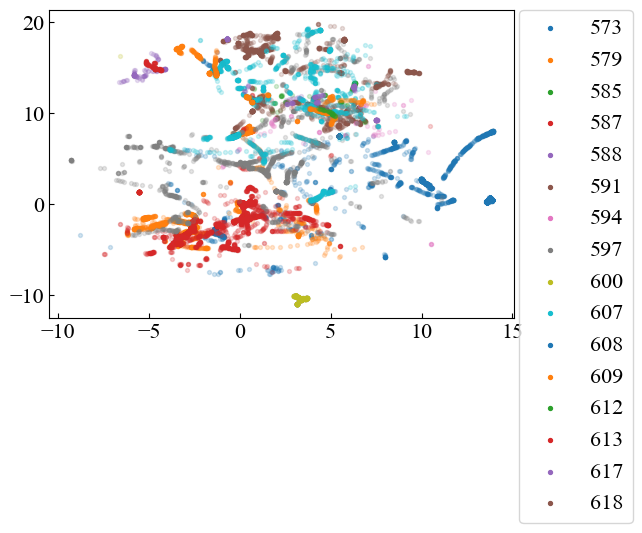

15


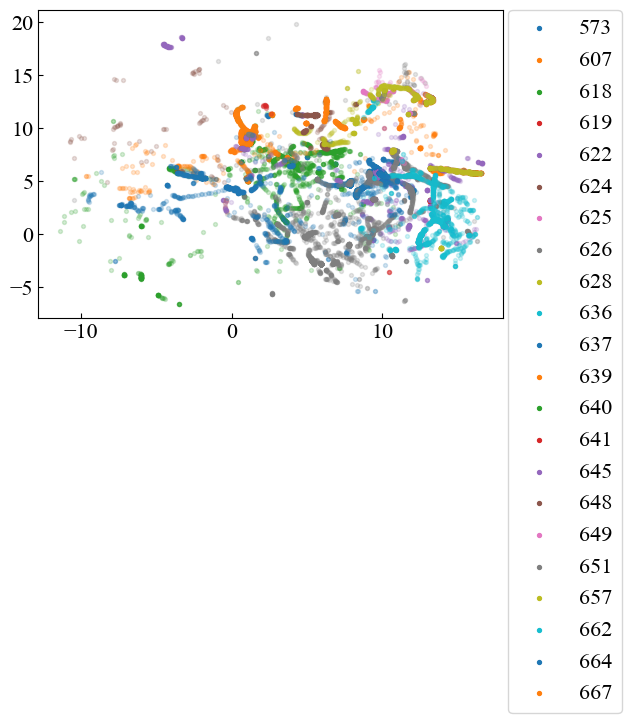

16


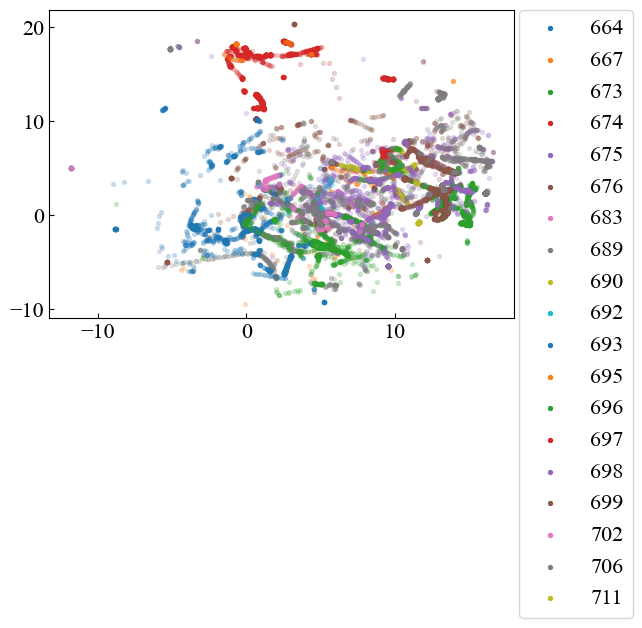

17


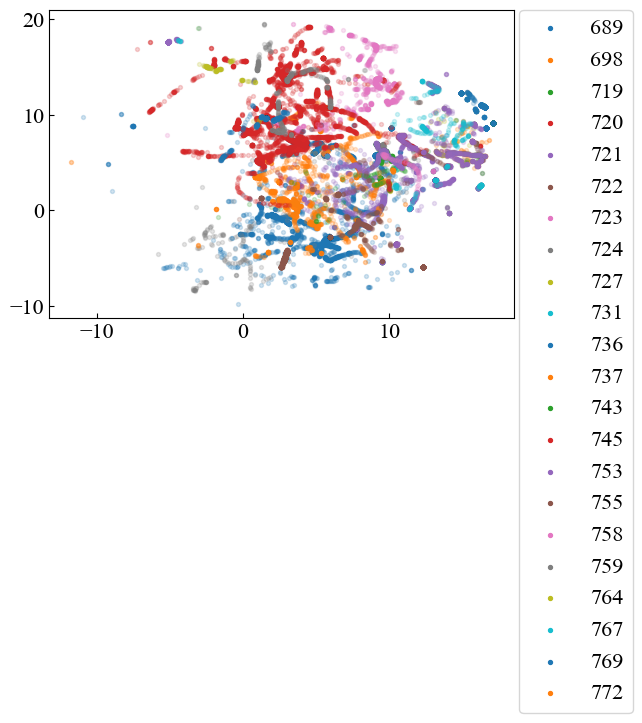

18


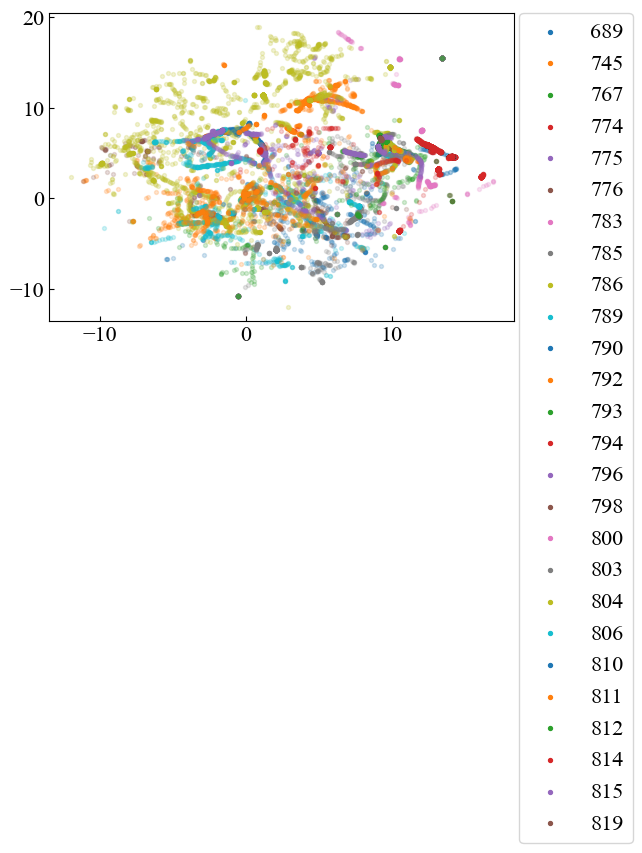

19


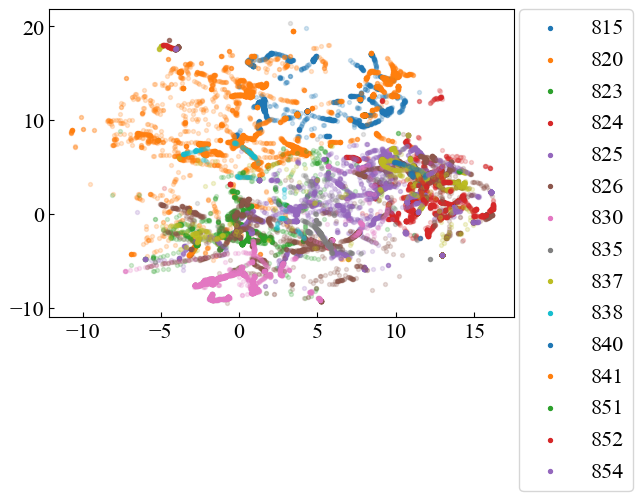

20


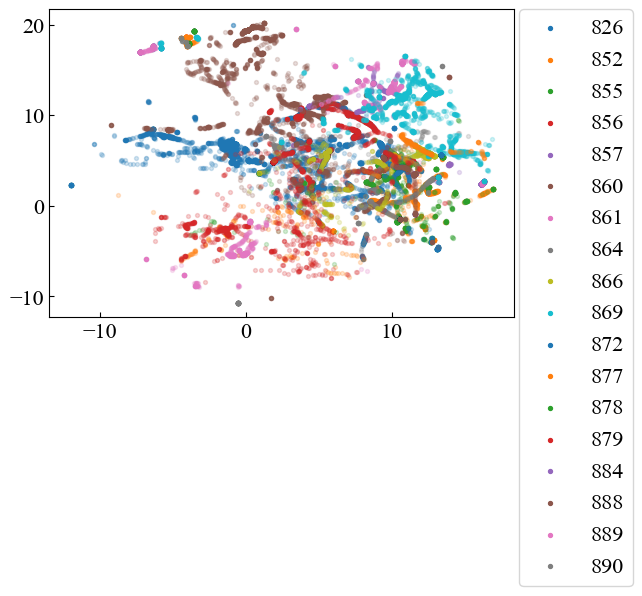

In [9]:
plot(test_results_ind, data_name, mappers, "test")

In [10]:
# release memory
del mappers, train_results_ind, test_results_ind